# Data Source
Capstone Project Name: PRCP-1001-RiceLeaf
Images (.jpg format) of Diseased Rice-Leaves as mentioned below:

###
1) Leaf smut - 39 images (.jpg)
2) Brown spot - 40 images (.jpg)
3) bacterial leaf blight - 40 images (.jpg)*

# Objective
The objective is to train a Deep Neural Network model using the abovementioned images to identify the corresonding disease in the rice plant.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import label_binarize,  LabelBinarizer


In [2]:
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers,utils
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.metrics import accuracy
from keras.utils import to_categorical 

In [3]:
from google.colab import drive

In [4]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data"

'Bacterial leaf blight'  'Leaf smut'		       Trained_CNN.h5
'Brown spot'		  Rice_Leaf_Model_Weights.h5   Trained_CNN.json


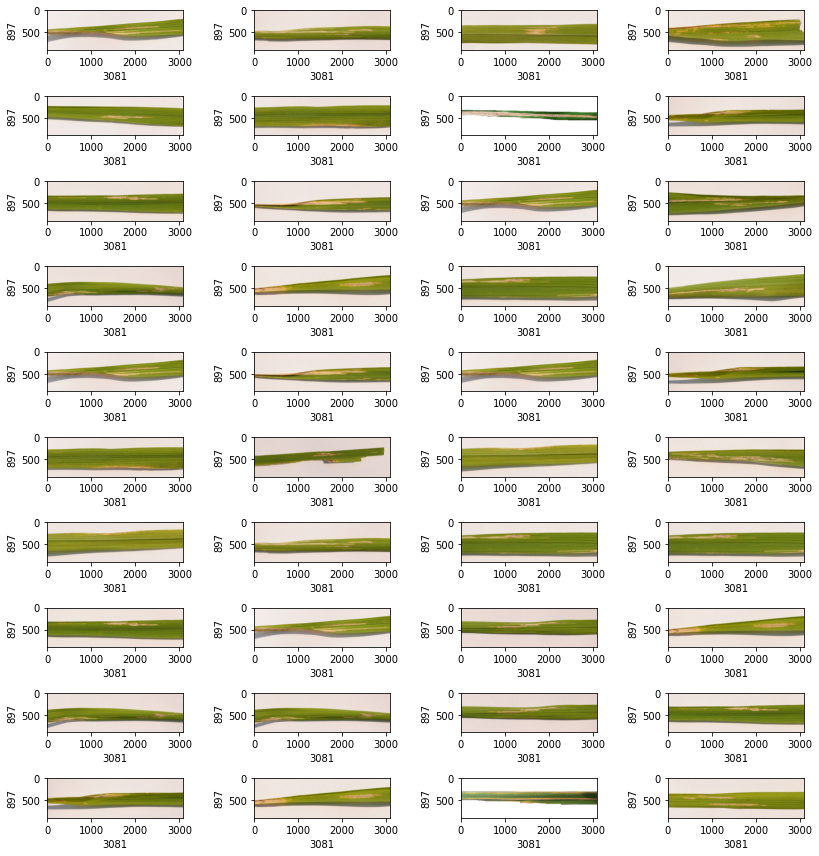

In [6]:
# Plotting 40 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Bacterial leaf blight/Bacterial leaf blight"
for i in range(1,41):
    plt.subplot(10,4,i)
    plt.tight_layout()
    bact_blight = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(bact_blight)
    plt.xlabel(bact_blight.shape[1], fontsize = 10)#width of image
    plt.ylabel(bact_blight.shape[0], fontsize = 10)#height of image

### Observation: 
These images correspond to the leaves from plant infected with Bacterial Leaf Blight

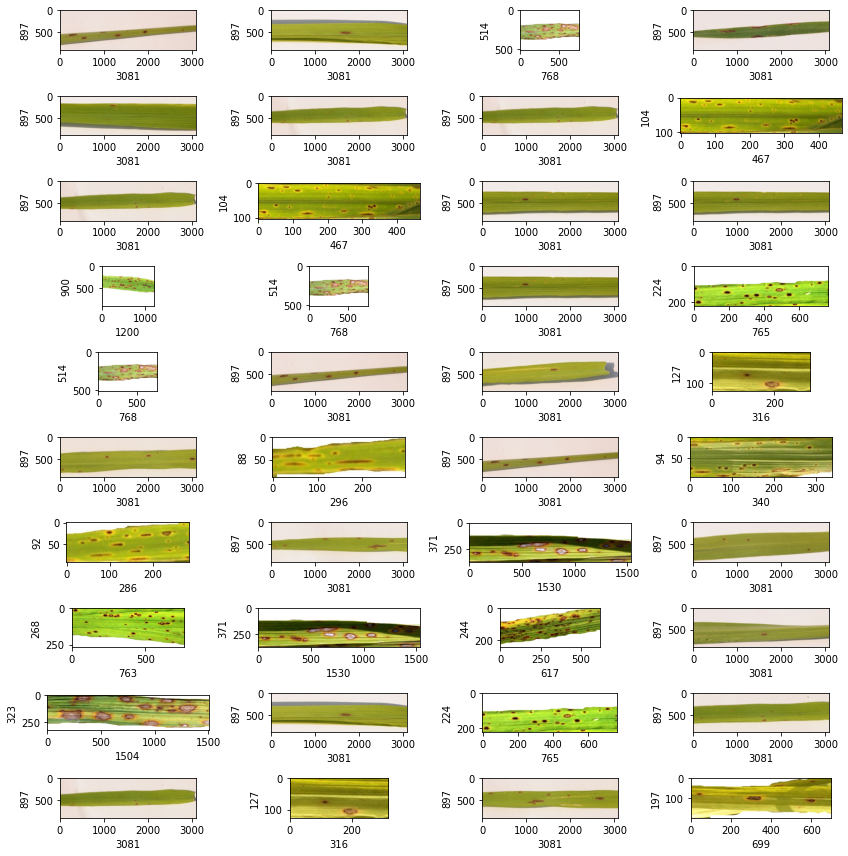

In [7]:
# Plotting 40 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Brown spot/Brown spot"
for i in range(1,41):
    plt.subplot(10,4,i)
    plt.tight_layout()
    brown_spot = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(brown_spot)
    plt.xlabel(brown_spot.shape[1], fontsize = 10)#width of image
    plt.ylabel(brown_spot.shape[0], fontsize = 10)#height of image

### Observation: 
These images correspond to the leaves from plant infected with Brown Spot Leaves

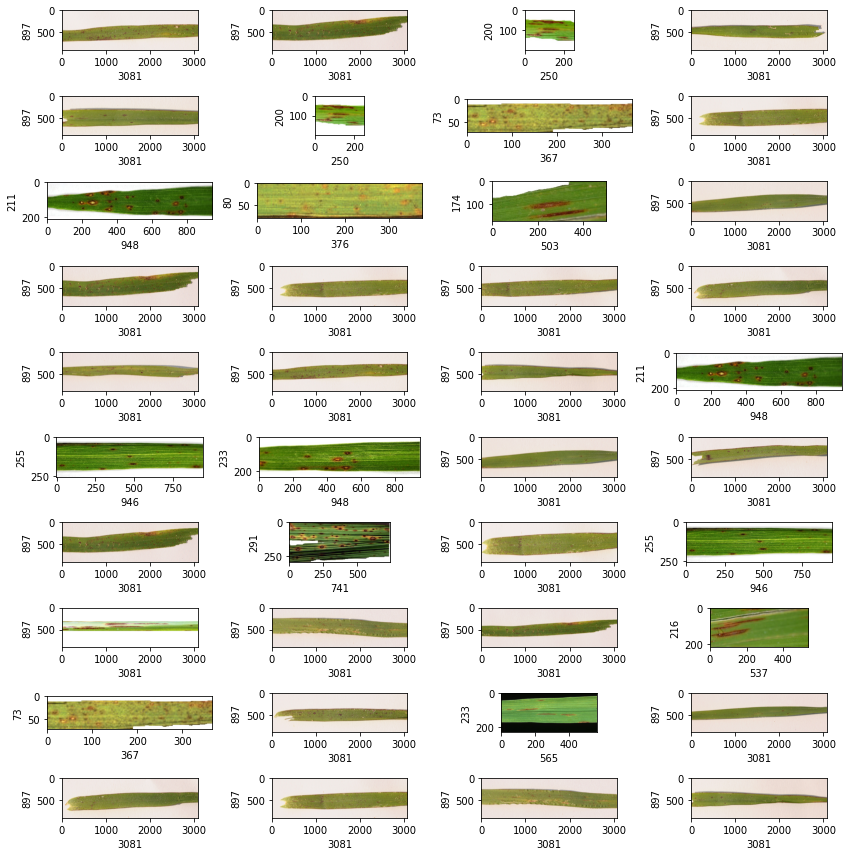

In [8]:
# Plotting 40 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Leaf smut/Leaf smut"
for i in range(1,41):
    plt.subplot(10,4,i)
    plt.tight_layout()
    Leafsmut = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(Leafsmut)
    plt.xlabel(Leafsmut.shape[1], fontsize = 10)#width of image
    plt.ylabel(Leafsmut.shape[0], fontsize = 10)#height of image

### Observation: 
These images correspond to the leaves from plant infected with Leaf Smut

### Next plan of actions:
After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [9]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (128,384))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [10]:
dir = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Leaves"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Bacterial_leaf_blight', 'Brown_spot', 'Leaf_smut']
target_labels = [0,1,2] 
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(target_labels[temp])

### Observation: 
- In the above cell we have encoded the various disease categories (target categories) into taget_lables (numbers: 0, 1 & 2).
- Then, We converted all the training images into numpy arrays.

In [11]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

1    40
2    40
0    39
dtype: int64

###Observation: 
Checked the number of images of various class labels and hence, confirmed the image dataset to be balanced:

In [12]:
#Checking the shape of the converted numpy array
image_list[0].shape

(384, 128, 3)

###Observation: 
- The colored images have been converted into a 3-D Matrix (Pixel_Pos_Height, Pixel_Pos_Width,RGB_Channel)
  

In [13]:
label_list = np.array(label_list)
label_list.shape

(119,)

###Observation: 
- Checking the total number of the images which is the length of the labels list.

### Next plan of action:
- Now that we have converted all our images into numpy arrays, let us we  use sklearn train_test_split to split the dataset into testing and training data. 
- Here we will test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 42) 

In [15]:
x_train[0].shape

(384, 128, 3)

### Normalise the pixel values:
- Now, we will normalize the dataset of our images to values between 0 & 1.
- This will reduce computation time and bring all the pixel samples to same scale (0 to 1).
- As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.
- Also, let us reshape the array of each sample to 768,256,3 in order to maintain constant aspect ratio.

In [16]:
#Scaling the pixel sizes to between 0 & 1:   
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0

#reshaping the array to maintain the aspect ratio of the image:
x_train = x_train.reshape( -1, 384,128,3) 
x_test = x_test.reshape( -1, 384,128,3)

In [17]:
#Checking for first sample (array) in the x_train
x_train[0,:,:,:]


array([[[1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        ...,
        [0.196  , 0.855  , 0.8823 ],
        [0.2    , 0.847  , 0.859  ],
        [0.2274 , 0.851  , 0.863  ]],

       [[1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        ...,
        [0.196  , 0.855  , 0.8823 ],
        [0.2    , 0.847  , 0.859  ],
        [0.2274 , 0.851  , 0.859  ]],

       [[1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        [1.     , 1.     , 1.     ],
        ...,
        [0.1921 , 0.851  , 0.8784 ],
        [0.1921 , 0.8394 , 0.851  ],
        [0.2196 , 0.8433 , 0.855  ]],

       ...,

       [[0.2432 , 0.5845 , 0.7607 ],
        [0.2588 , 0.604  , 0.7764 ],
        [0.2744 , 0.6313 , 0.8076 ],
        ...,
        [0.0196 , 0.392  , 0.3882 ],
        [0.00784, 0.392  , 0.392  ],
        [0.02745, 0.408  , 0.4197 ]],

       [[0.2393 , 0.5806 , 0.757  ],
  

In [18]:
#Checking for shape of array corresponding to image samples
print(x_train[0,:,:,:].shape,x_train[-1,:,:,:].shape)


(384, 128, 3) (384, 128, 3)


In [19]:
#Checking for shape of x_train
x_train.shape

(95, 384, 128, 3)

In [20]:
#Checking for shape of x_train
x_test.shape

(24, 384, 128, 3)

In [21]:
#Checking for dtype of array corresponding to image samples
print(x_train[0,:,:,:].dtype,x_train[-1,:,:,:].dtype)


float16 float16


### Observations:
- x_train shape: (95, 384,128,3)
- x_test shape: (24, 384,128,3)
- datatype of the sample array (tensor) float16

### Convert the Target into categorical type:
- As, our business case is to classify the type of disease in the leaf samples (classification problem) we can convert the target variable (target labels (0,1,2) as categorical datatype for further processing.  

In [22]:
# Checking the datatype
print(y_train.dtype,y_test.dtype)

int64 int64


In [23]:
# Converting the target feature (one-hot encoding) for Keras (Tensorflow2)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
# Checking the datatype after conversion
print(y_train.dtype,y_test.dtype)

float32 float32


In [25]:
#Let us split the train dataset into train & validation dataset 
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

# Initialize a CNN Object from keras module:

- Let us create a sequential CNN model using keras and hence add successive convolution layers, pooling layers, flattening layer, dense layer, and activation layer as mentioned below: 


Case--> I:
As the images of the diseased leaves don't have much contrasting pixels, instead of using MaxPooling2D layer, let us first try AveragePoolingLayer from Keras. 

In [26]:
num_classes = 3
model1 = Sequential([
  layers.Conv2D(filters=256,kernel_size= (3,3), padding='valid', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Flatten(),
  layers.Dense(units=512, activation='relu'),
  layers.Flatten(),
  layers.Dense(units=num_classes,activation='softmax')
])



In [27]:
# creating a stochastic gradient descent object from keras.optimizers class  
opt = SGD(learning_rate=0.0003, momentum=0.99)

# compile the model with loss function:categorical_crossentropy, SGD optimizer & accuracy metric
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
#Training the model with Batch SGD model as initialized above with sample batch size:16 for 500 epochs
epochs=500
batch_size=16
history = model1.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val),verbose=100)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

### Plotting the training graph of model-1 through various epochs
Let's plot the accuracy of the model for the trainig history.

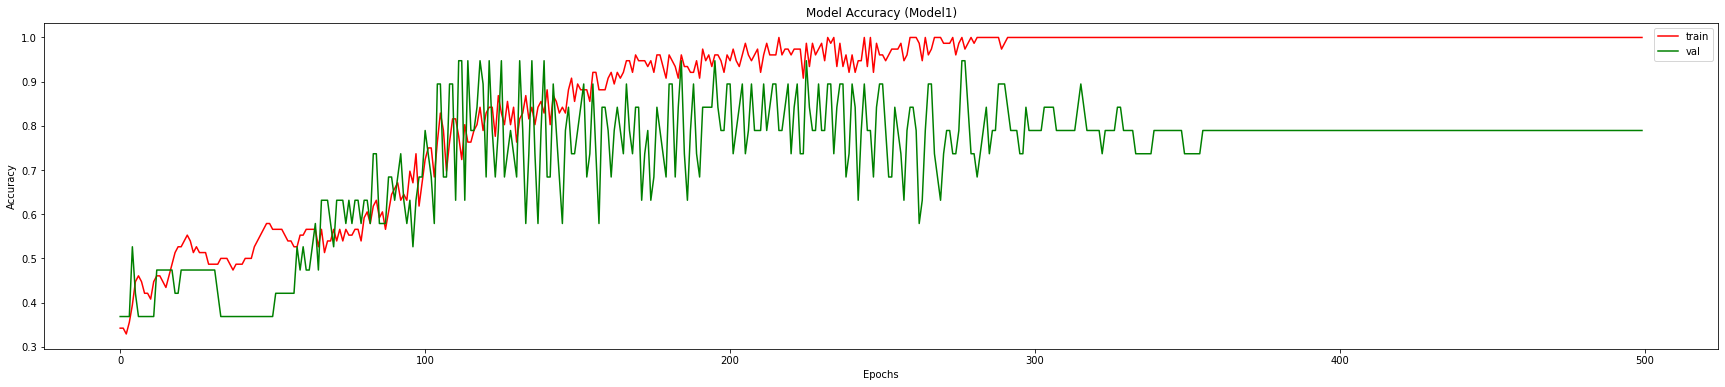

In [29]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Model1')
plt.title('Plot of training Epoches (Model1)')
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='g')
plt.title('Model Accuracy (Model1)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

### Observations:
From the plot, it can be observed that:
- The train accuracy is very high (>98%) whereas the validation accuracy is moderately good around 70%. 

### Checking for Test Accuracy
- Now, let's check the accuracy of the trained model (Model1) for test data. 

In [30]:
print("[INFO] Calculating model accuracy (Model1)")
scores1 = model1.evaluate(x_test, y_test)
print(f"Test Accuracy using Model1: {scores1[1]*100}")

[INFO] Calculating model accuracy (Model1)
1/1 [==============================] - 1s 886ms/step - loss: 3.7816 - accuracy: 0.6250
Test Accuracy using Model1: 62.5


In [31]:
# Predicting the test data using this model
y_pred1 = model1.predict(x_test)

1/1 [==============================] - 0s 103ms/step


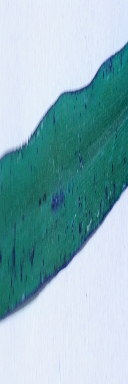

In [32]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [33]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted using model1: ",all_labels[np.argmax(y_pred1[10])])

Originally :  Bacterial_leaf_blight
Predicted using model1:  Bacterial_leaf_blight


### Observation: 
- The abovementioned class prediction by the trained model (model1) was correct.

Case--> II:
Let us construct another model, Model 2 by reorganising the various convolutional layers as applied in Model 1 

In [34]:
num_classes = 3
model2 = Sequential([
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',input_shape=(384, 128, 3)),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=128,kernel_size= (3,3), padding='valid', activation='relu'),
  layers.AveragePooling2D(pool_size=(3,3)),
  layers.Flatten(),
  layers.Dense(units=512, activation='relu'),
  layers.Flatten(),
  layers.Dense(units=num_classes,activation='softmax')
])



In [35]:
# creating a stochastic gradient descent object from keras.optimizers class  
opt2 = SGD(learning_rate=0.0003, momentum=0.99)

# compile the model with loss function:categorical_crossentropy, SGD optimizer & accuracy metric
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])

In [36]:
#Training the model with Batch SGD model as initialized above with sample batch size:16 for 500 epochs
epochs=500
batch_size=16
history2 = model2.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val),verbose=100)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

### Plotting the training graph of model-2 through various epochs
Let's plot the accuracy of the model for the trainig history.

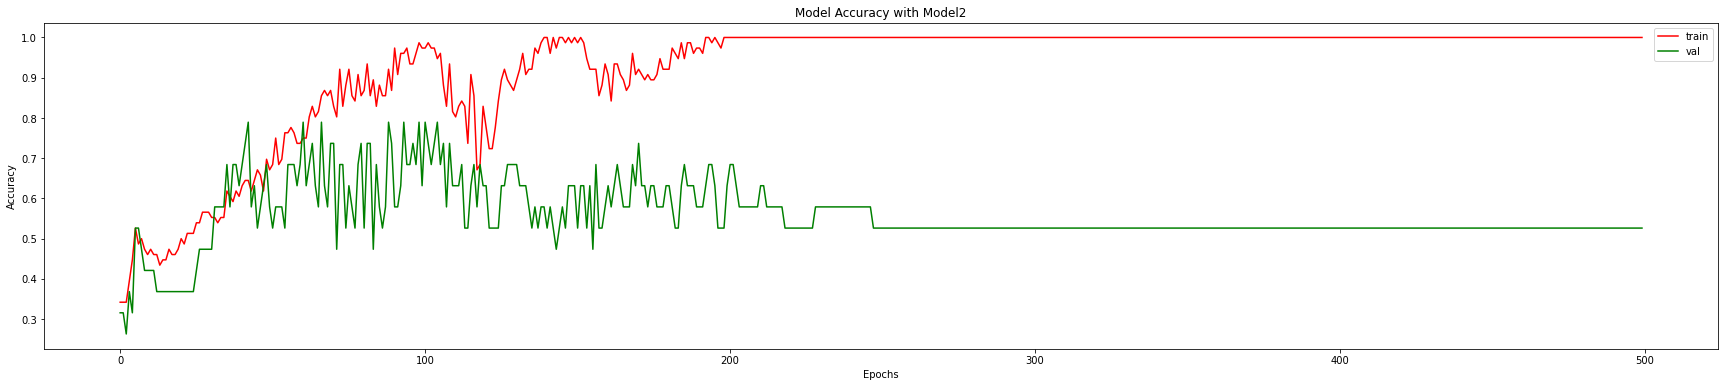

In [37]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Plot of training Epoches with Model2')
plt.plot(history2.history['accuracy'], color='r')
plt.plot(history2.history['val_accuracy'], color='g')
plt.title('Model Accuracy with Model2')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

### Observations:
From the plot, it can be observed that:
- The train accuracy for this model is high. But, validation accuracy is very poor


### Checking for Test Accuracy using model2
- Now, let's check the accuracy of for test data using Model2. 

In [38]:
print("[INFO] Calculating model accuracy (Model2)")
scores2 = model2.evaluate(x_test, y_test)
print(f"Test Accuracy(Model2): {scores2[1]*100}")

[INFO] Calculating model accuracy (Model2)
1/1 [==============================] - 1s 581ms/step - loss: 12.6211 - accuracy: 0.5417
Test Accuracy(Model2): 54.16666865348816


In [39]:
# Predicting the test data using this model
y_pred2 = model2.predict(x_test)

1/1 [==============================] - 0s 80ms/step


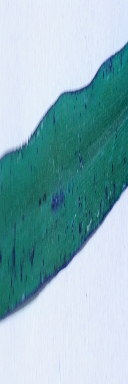

In [40]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [41]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted using Model2: ",all_labels[np.argmax(y_pred2[10])])

Originally :  Bacterial_leaf_blight
Predicted using Model2:  Bacterial_leaf_blight


### Observation: 
- The abovementioned class prediction by the trained model (model2) was correct.

Case--> III:
Now, let us build a CNN model using MaxPooling2D() instead of AveragePooling2D()

In [42]:
num_classes = 3
model3 = Sequential([
  layers.Conv2D(filters=256,kernel_size= (3,3), padding='valid', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Flatten(),
  layers.Dense(units=512, activation='relu'),
  layers.Flatten(),
  layers.Dense(units=num_classes,activation='softmax')
])



In [43]:
# creating a stochastic gradient descent object from keras.optimizers class  
opt3 = SGD(learning_rate=0.0003, momentum=0.99)

# compile the model with loss function:categorical_crossentropy, SGD optimizer & accuracy metric
model3.compile(loss='categorical_crossentropy', optimizer=opt3, metrics=['accuracy'])

In [44]:
#Training the model with Batch SGD model as initialized above with sample batch size:16 for 500 epochs
epochs=500
batch_size=16
history3 = model3.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val),verbose=100)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

### Plotting the training graph of model-1 through various epochs
Let's plot the accuracy of the model for the trainig history.

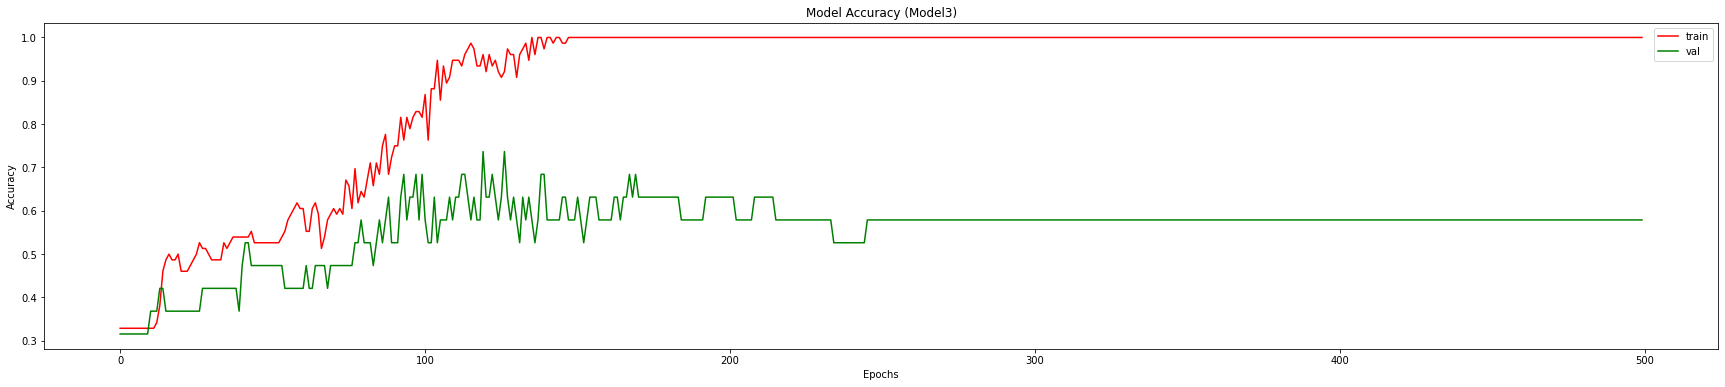

In [45]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Model3')
plt.title('Plot of training Epoches (Model3)')
plt.plot(history3.history['accuracy'], color='r')
plt.plot(history3.history['val_accuracy'], color='g')
plt.title('Model Accuracy (Model3)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

### Observations:
From the plot, it can be observed that:
- The train accuracy is very high (>0.95)
- However, the validation accuracy is very less (<0.60)

### Checking for Test Accuracy
- Now, let's check the accuracy of the trained model (Model3) for test data. 

In [46]:
print("[INFO] Calculating model accuracy (Model1)")
scores3 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy using Model3: {scores3[1]*100}")

[INFO] Calculating model accuracy (Model1)
1/1 [==============================] - 0s 77ms/step - loss: 3.9524 - accuracy: 0.5833
Test Accuracy using Model3: 58.33333134651184


In [47]:
# Predicting the test data using this model
y_pred3 = model3.predict(x_test)

1/1 [==============================] - 0s 78ms/step


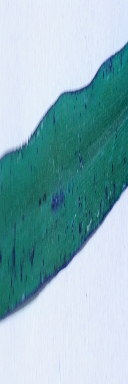

In [48]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [49]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted using model1: ",all_labels[np.argmax(y_pred3[10])])

Originally :  Bacterial_leaf_blight
Predicted using model1:  Bacterial_leaf_blight


### Observation: 
- The abovementioned class prediction by the trained model (model3) was correct.

### Conclusion:
We built and trained the 3 configurations of Covolutional Neural Network (CNN) models using Gradient Descent Optimizer:

- Model1-using sequential 2D covolutional layers, Averagepooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 62.5%

- Model2-using another sequential 2D covolutional layers, Averagepooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 54.17%

- Model3-using another sequential 2D covolutional layers, Maxpooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 58.33%

- We are concluding that model1 performed better classification of the unseend images.

- We understand that as Neural Networks require large amount of training data for training more accurate CNN models the total 77 images used for training the model are not sufficient to improve the model accuracy.

- If we had more images to train upon it would have been possible to train the CNN model more accurately and hence to attain higher accuracy to predict the test images.